In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE
from tensorflow.keras.callbacks import EarlyStopping

#---Import moduls from stock-prediction package
from stock_prediction.data_prep import Data_Prep
from stock_prediction.features_exo import exo_selection

# Test 1: LSTM
learning rate, momentum

## Data exploration

In [3]:
#---(1) Instantiate the Class 
prep_class = Data_Prep('vinci', 252)



#---(2) Load the first dataframe ready to use if no more modification
data = prep_class.data_prep()



#---(3) Function that allows us to delete some of the features we don't want to use for modelling 
# Log Return is to False by default
# *******************
# if period < 252 , don't use Annual_vol
#********************
prep_class.select_features(data, Return = True, Log_Return=False, High_Low=False, High_Close=True, Low_Close=True,
                        Volume_Change=True, Period_Volum=True, Annual_Vol=True,
                        Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

#---(4) Function that add the exogenous features that you need to select 
# returns the dataframe ready to modelling 
# and the list of the columns to rebase it later - no VIX because no rebase for VIX - kept unchanged 
data = exo_selection(data, sp500=True, gold=True, eurusd=False, nasdaq=False, crude=False, vix=True)

#---(5) Sort values to make sure they are ordered *in case and drop data column
data = data.sort_values('Date')
data = data.drop(columns='Date')

In [7]:
data.head()

,Return_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Volume-Change_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif,Return_S&P500,Return_Gold,Vix_No_Rebase
0,0.015547,0.007076,0.015150,0.963615,0.331698,0.202937,0.202937,-0.001862,0.000000,0.017409,-0.007514,0.007844,0.1041
1,-0.002187,0.009799,0.002456,-0.407210,-0.209472,0.202602,0.202602,0.003497,0.000000,-0.005684,-0.003694,-0.003931,0.0989
2,0.006833,0.002689,0.006314,-0.156808,-0.332583,0.202592,0.202592,0.006953,-0.186563,-0.000119,0.001219,0.007735,0.0975
3,-0.003713,0.005913,0.003224,-0.368494,-0.577419,0.201847,0.201847,0.000000,0.000000,-0.003713,0.002787,0.001958,0.1007
4,-0.013239,0.008727,0.001043,0.957079,-0.171234,0.201653,0.201653,-0.010479,-0.215993,-0.002760,-0.001566,0.011803,0.1045


In [6]:
data.shape

(1027, 13)

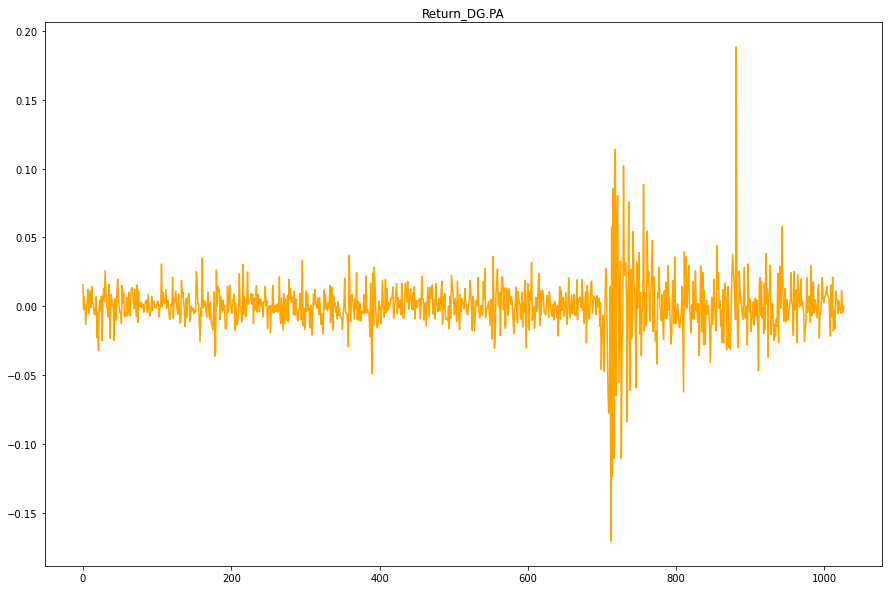

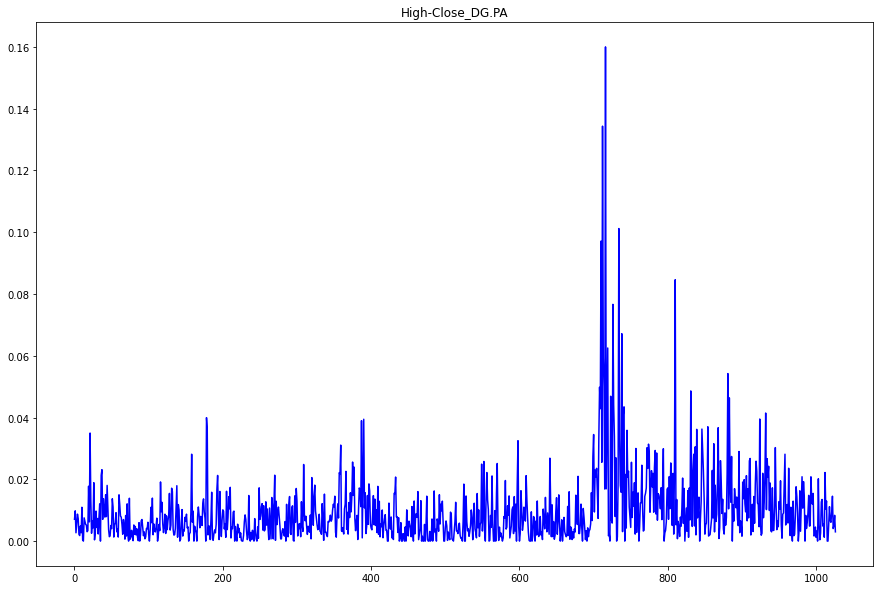

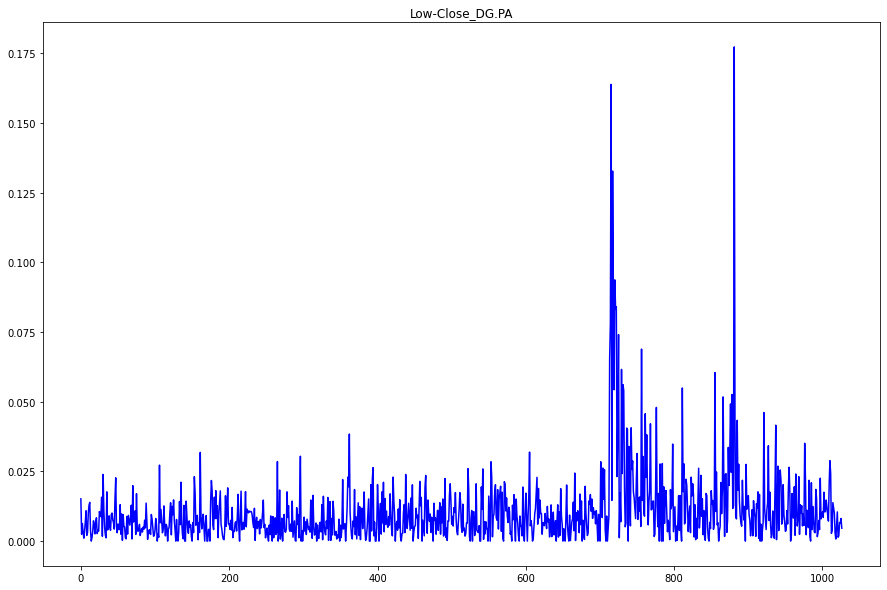

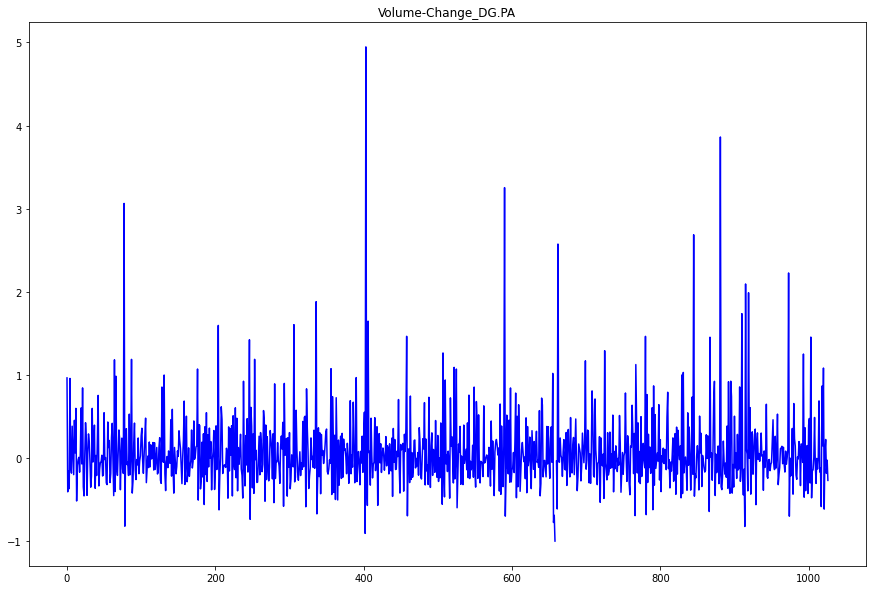

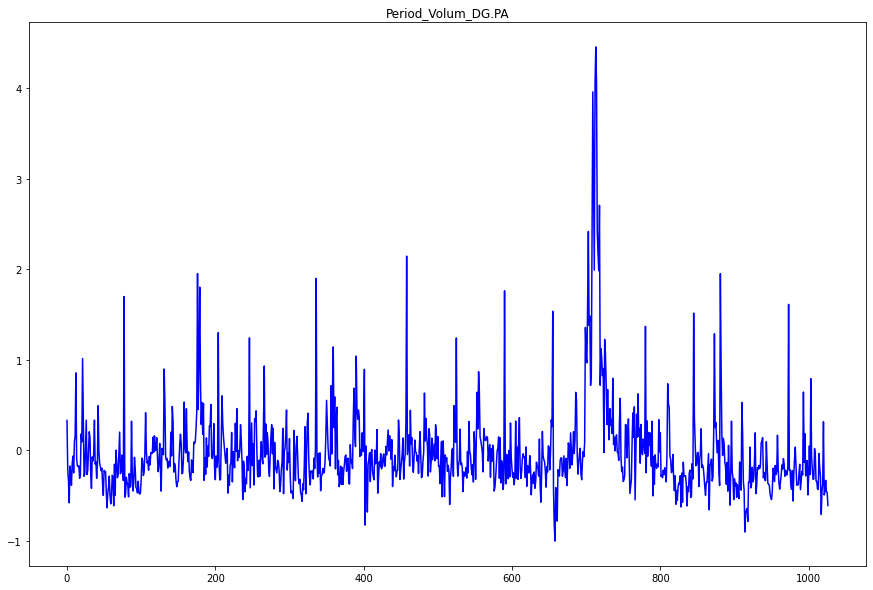

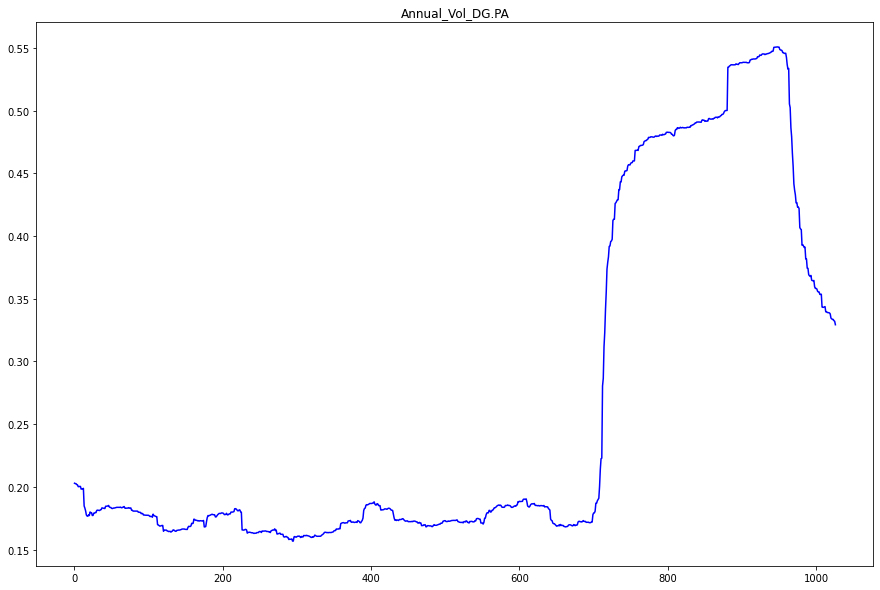

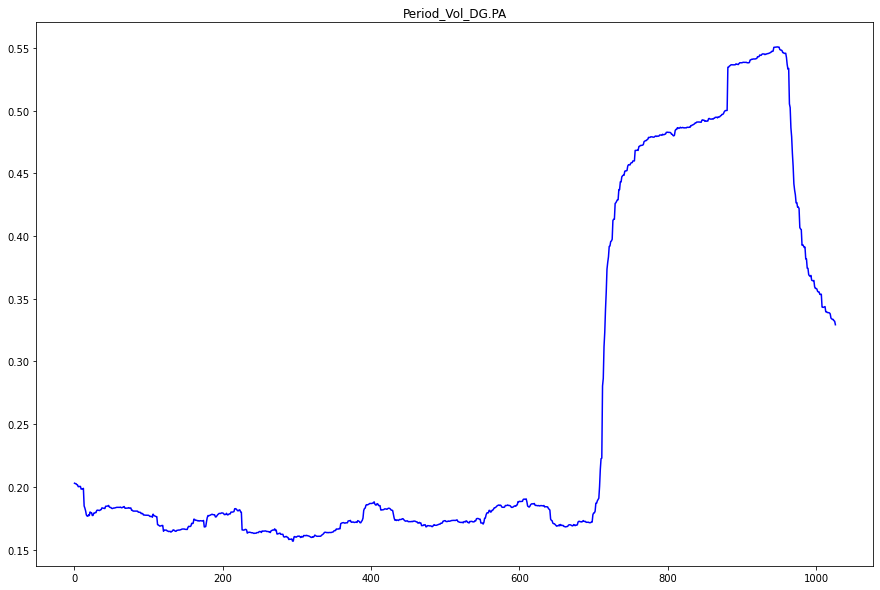

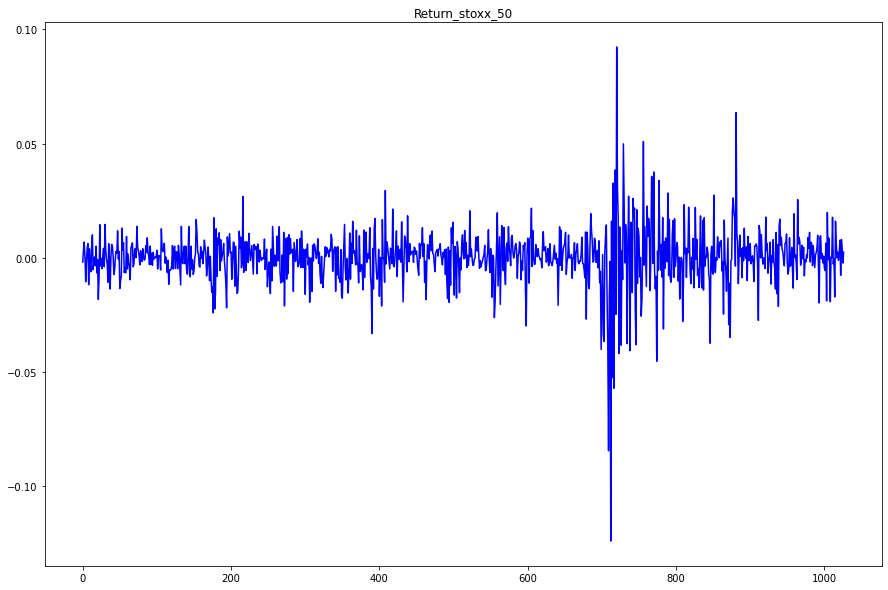

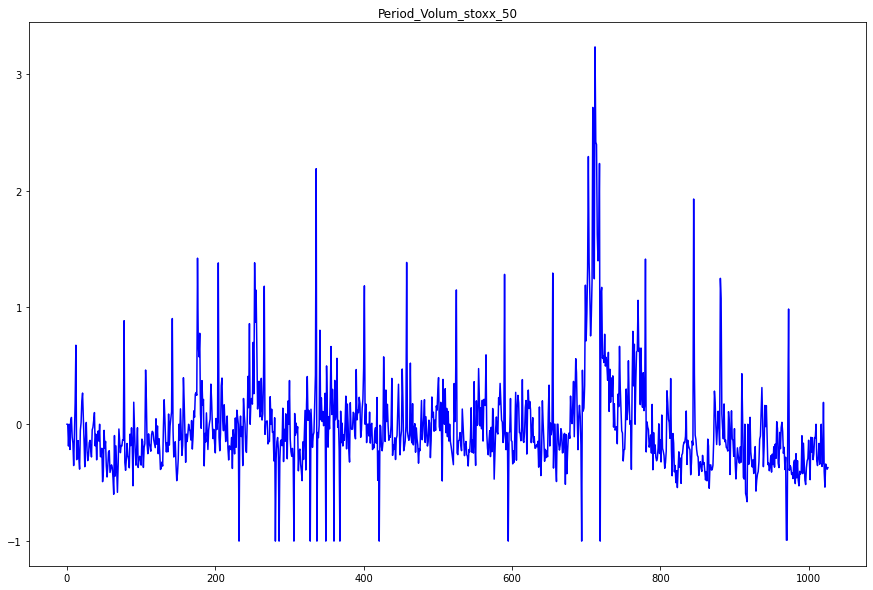

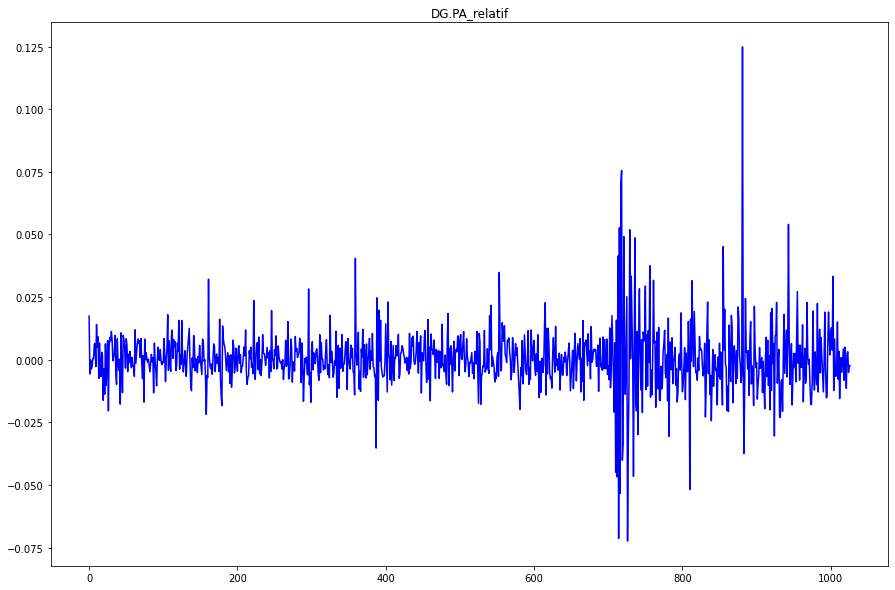

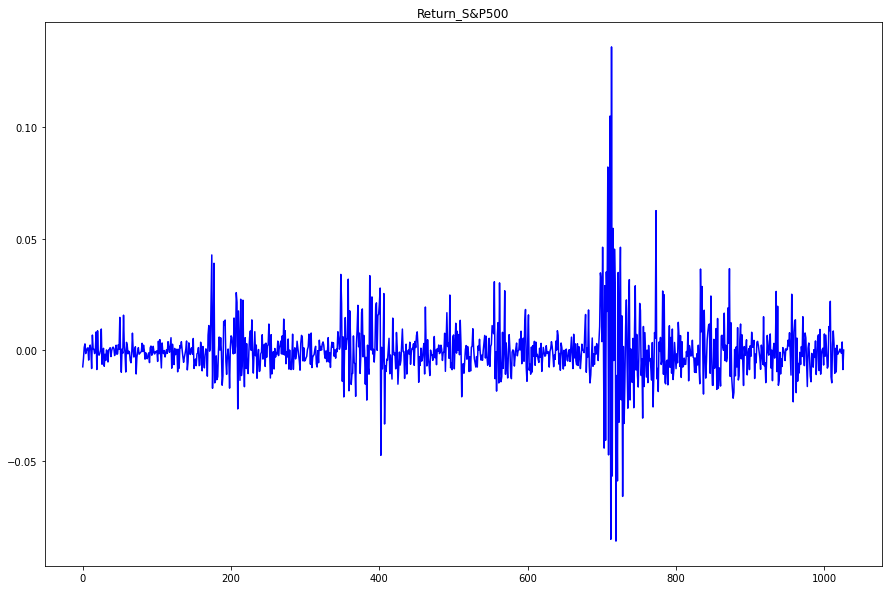

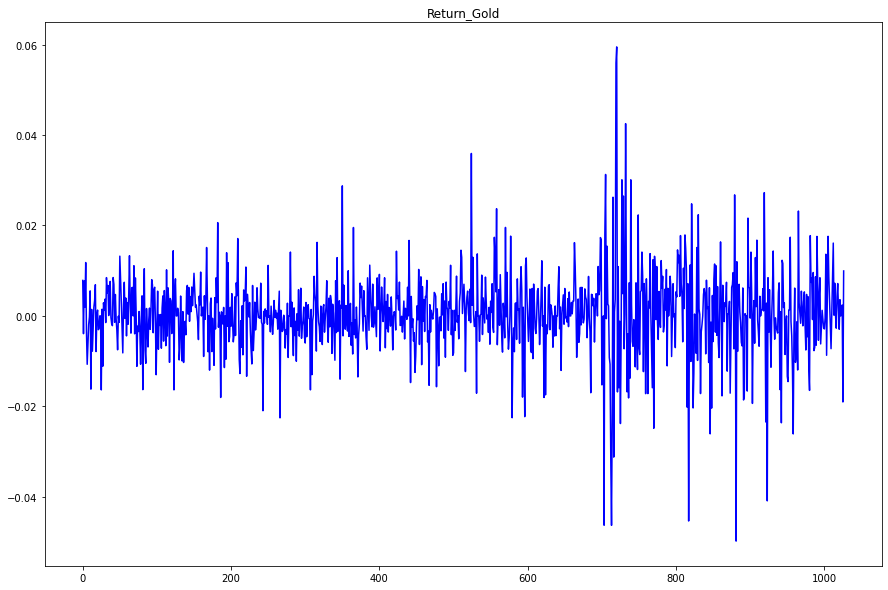

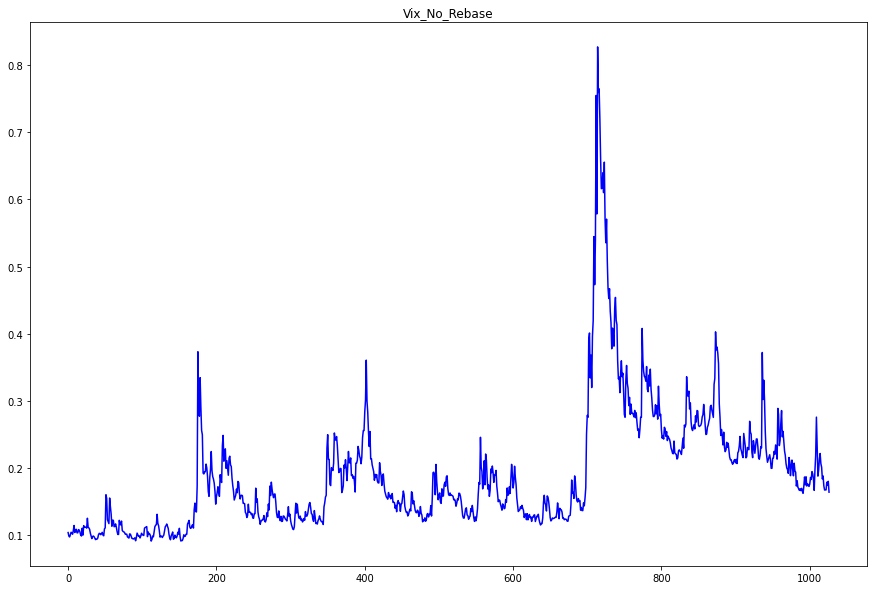

In [27]:
#---Plot the temporal progression of different features of our Data

%matplotlib inline

for col in data.columns:
    color="orange" if col == "Return_DG.PA" else "blue"
    data[col].plot(figsize=(15, 10), color=color)
    plt.title(col)

    plt.show()

## Data preprocessing TS oriented

In [42]:
# To avoid data leakage we have to split sets chronologically.

def train_test_val_split(df, horizon=1, train_threshold=0.6, val_threshold=0.8):
    
    # here gap=0, if we take a longer horizon it'll matter
    gap = horizon - 1

    # set a train: 60%, test: 20%, val: 20% sizes
    train = int( train_threshold*df.shape[0])
    val = int(val_threshold*df.shape[0])


    df_train = df[:train]
    df_val = df[train:val]
    df_test = df[val+gap:] # gap can matter later
    
    return df_train, df_val, df_test

In [48]:
def subsample_sequence(df, length=10, horizon=1): #, target = 'DG.PA'
    
    """This function is able to get a subsequence X and a corresponding target y
    N days after the last observationexpressed in horizon variable."""
    
    last_possible = df.shape[0] - length - horizon
    
    random_start = np.random.randint(0, last_possible) #raandom seed  = 0
    
    X = df[random_start: random_start+length].values # drop(columns=[f'Return_{target}']).
    
    # target: Close price to predict
    y = df.iloc[random_start+length+horizon]['Return_DG.PA'] # [f'Return_{target}']; taregt = 'Return'

    return X, y

In [44]:
def get_X_y(df, length=10, horizon=1, number_of_sequences=100):
    
    """This function returns a given number of X and y sequences of given length."""
    
    X, y = [], []

    for _ in range(int(number_of_sequences)):
        
        xi, yi = subsample_sequence(df, length, horizon)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

## Model RNN

In [87]:
#---Pipeline
def train_model(df,
                train_threshold=0.6,
                val_threshold=0.8,
                nb_sequences = 100,
                len_ = 20,
                l_rate = 0.001,
                momentum = 0,
                loss = 'mse',
                metric = MAPE,
                patience = 10,
                batch_size = 32,
                horizon=1,
                plot_history=False):
    
    """Train model function:
    Allows to split sequences and gets X and y for train, val, test sets;
    Initializes stacked RNN model with Normalization, LSTM and 2 fully connected layers"""
    

    #---Split train, test, val sets
    df_train, df_val, df_test = train_test_val_split(df, train_threshold=train_threshold, val_threshold=val_threshold)
    
    #---Get train, test, val X and y sequences
    X_train, y_train = get_X_y(df_train, length=len_, number_of_sequences=nb_sequences)
    X_val, y_val = get_X_y(df_val, length=len_, number_of_sequences=round(nb_sequences*0.2))
    X_test, y_test = get_X_y(df_test, length=len_, number_of_sequences=round(nb_sequences*0.2))
    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #---Initialize the model
    model = Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    
    model.compile(loss=loss, 
                  optimizer=RMSprop(learning_rate=l_rate, momentum=momentum), 
                  metrics=[metric])


    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1000, 
            batch_size=batch_size,
            callbacks=[es],
            verbose=0)

    
    if plot_history:
        
        plot_loss(history, patience)
        
#     res = model.evaluate(X_test, y_test, verbose=0)
#     return res[1]
    return X_train, y_train, X_test, y_test, model

In [69]:
#---Plot train val losses function

def plot_loss(history, patience):
    plt.plot(history.history['loss']) # plot train loss
    plt.plot(history.history['val_loss']) # plot val loss
    plt.title('MSE')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mean_absolute_percentage_error'])
    plt.plot(history.history['val_mean_absolute_percentage_error'])
    plt.title('MAPE')
    plt.ylabel('Mean Absolute Percentage Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    stop_epoch = max(history.epoch)-patience
    val_mape = history.history['val_mean_absolute_percentage_error'][stop_epoch]

    print(f"early stopping at {max(history.epoch)} epoch.\nval_mape: {val_mape}")

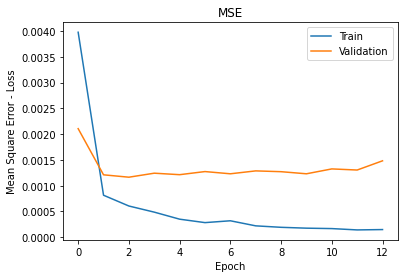

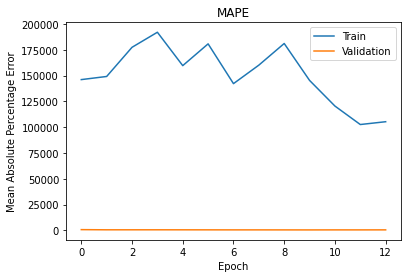

early stopping at 12 epoch.
val_mape: 481.7250061035156


In [88]:
X_train, y_train, X_test, y_test, model = train_model(df = data, plot_history=True)

Prediction of stock return on J+1: [[-0.04239883]
 [-0.04555728]
 [-0.04199546]
 [-0.04957949]
 [-0.05130275]
 [-0.04015188]
 [-0.03233217]
 [-0.03955386]
 [-0.05146741]
 [-0.02043393]
 [-0.02644478]
 [-0.03987214]
 [-0.02071836]
 [-0.04345426]
 [-0.01193404]
 [-0.03381151]
 [-0.00350403]
 [-0.05988974]
 [-0.00599726]
 [-0.03480486]] with mape 920.3234252929688


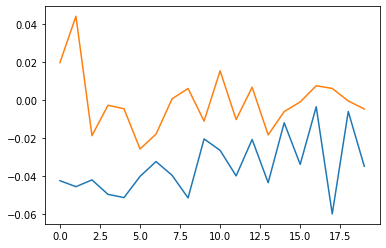

In [92]:
#---Prediction
res = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
plt.plot(y_pred)
plt.plot(y_test)
print(f"Prediction of stock return on J+1: {y_pred} with mape {res[1]}")

**Baseline**

In [ ]:
#TODO
# y_pred = last seen value
# bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

# print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

In [54]:
#df_test
df_train, df_val, df_test = train_test_val_split(data) #train_threshold=0.6, val_threshold=0.8 to test !

# X_test & y_test
X_test, y_test = get_X_y(df_test, length=20)

In [75]:
data.head()

,Return_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Volume-Change_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif,Return_S&P500,Return_Gold,Vix_No_Rebase
0,0.015547,0.007076,0.015150,0.963615,0.331698,0.202937,0.202937,-0.001862,0.000000,0.017409,-0.007514,0.007844,0.1041
1,-0.002187,0.009799,0.002456,-0.407210,-0.209472,0.202602,0.202602,0.003497,0.000000,-0.005684,-0.003694,-0.003931,0.0989
2,0.006833,0.002689,0.006314,-0.156808,-0.332583,0.202592,0.202592,0.006953,-0.186563,-0.000119,0.001219,0.007735,0.0975
3,-0.003713,0.005913,0.003224,-0.368494,-0.577419,0.201847,0.201847,0.000000,0.000000,-0.003713,0.002787,0.001958,0.1007
4,-0.013239,0.008727,0.001043,0.957079,-0.171234,0.201653,0.201653,-0.010479,-0.215993,-0.002760,-0.001566,0.011803,0.1045


In [73]:
X_test.shape

(100, 10, 13)

In [76]:
# # Or (better) we predict the last stock closing price value!
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

Benchmark MAPE on the test set : inf %


<ipython-input-76-bd29faa9563e>:3: RuntimeWarning: divide by zero encountered in true_divide
  bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100


**Plot sequences**

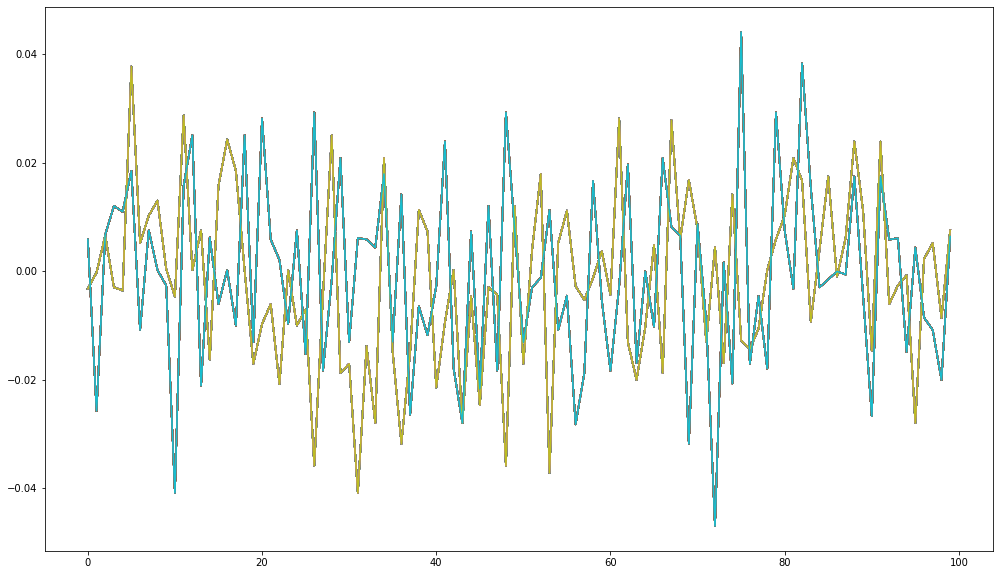

In [83]:
# ---Plot observations of 1st sequence for Open and Close prices
plt.figure(figsize=(17,10))
for _ in range(100):
    plt.plot(y_pred_baseline)
    plt.plot(y_test)